# Data and introduction

In [1]:
import pandas as pd

import numpy as np

## load the dataset 
## Source: https://www.kaggle.com/uciml/pima-indians-diabetes-database/download
df = pd.read_csv('data/diabetes.csv')
display(df.head(),df.shape)



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


(768, 9)

In [2]:
## separate target variable from features
target = df.Outcome
column_list = [i for i in df.columns if i!= 'Outcome']

print(column_list)

X = df[column_list]

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


<Figure size 720x1080 with 0 Axes>

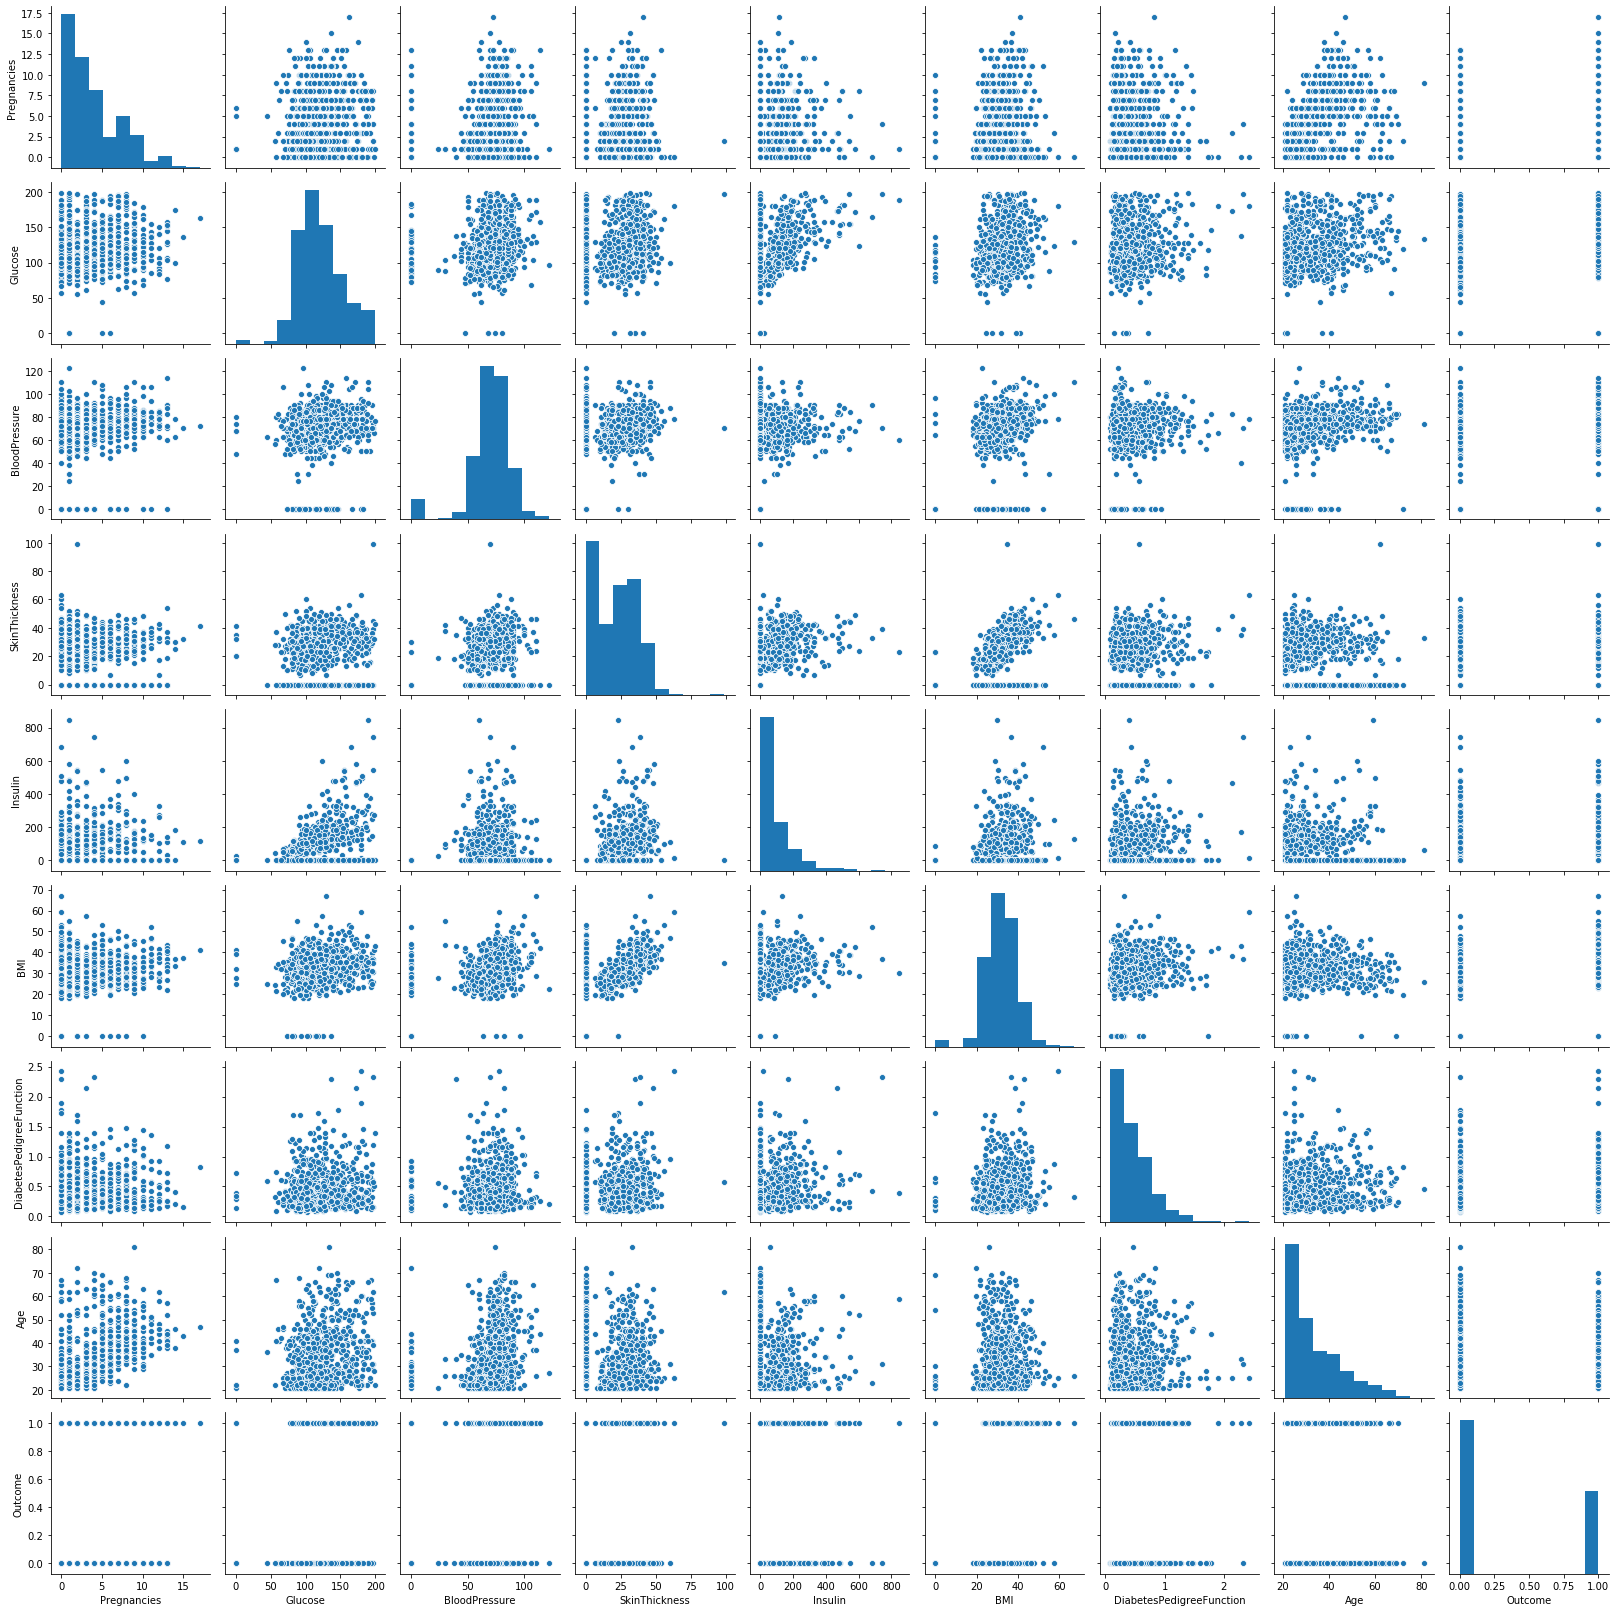

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize= (10,15))
sns.pairplot(df)
plt.tight_layout();

In [100]:
## Let's see the distribution of 1's and 0's
np.unique(target, return_counts= True)

(array([0, 1]), array([500, 268]))

## Creating a Baseline with Logreg



In [102]:
from sklearn.model_selection import train_test_split, cross_val_score

## Split data into test train
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    target,
                                                    test_size=0.20,
                                                    stratify= target,
                                                    random_state = 120919)

In [103]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [105]:
pipe = Pipeline([('ss', StandardScaler()),
                 ('log_reg', LogisticRegression(C = 1000,
                                                max_iter = 1000, 
                                                solver = 'saga'))])                            

## we can access to a particular step in the pipeline

print(pipe.steps[0])

print(pipe['log_reg'])

('ss', StandardScaler(copy=True, with_mean=True, with_std=True))
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


In [107]:
## let's use fit method from pipeline
pipe.fit(X_train, y_train)


pipe.score(X_train, y_train)

0.7671009771986971

In [152]:
## to find a best value for the C
## let's use GridSearchCV

from sklearn.model_selection import GridSearchCV
grid = [{'log_reg__C': np.logspace(-2,2,10, base = 10.0), 
                'log_reg__penalty': ['l1', 'l2']}]

gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='recall',
                  cv=5, n_jobs=-1, 
                    return_train_score= True)

gridsearch.fit(X_train, y_train);

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [153]:
print(gridsearch.cv_results_['mean_test_score'])
print(gridsearch.cv_results_['mean_train_score'])

[0.         0.41607057 0.42065717 0.50021643 0.50953391 0.51899567
 0.52365441 0.53297189 0.53763063 0.53297189 0.53763063 0.53297189
 0.53763063 0.53763063 0.53763063 0.53763063 0.53763063 0.53763063
 0.53763063 0.53763063]
[0.         0.40888753 0.40655515 0.50819393 0.52337821 0.53854889
 0.54323405 0.54906161 0.55142119 0.55374677 0.55492996 0.55843193
 0.55843193 0.55960152 0.55960152 0.56077111 0.55960152 0.56077111
 0.56077111 0.56077111]


In [150]:
best_est = gridsearch.best_estimator_

In [138]:
y_pred = best_est.predict(X_train)

In [139]:
pd.DataFrame(confusion_matrix(y_train, y_pred), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,353,47
actual 1,93,121


In [146]:
best_est['log_reg'].get_params()

{'C': 0.5994842503189409,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# Boosting Algorithms 

Source: This notebook is motivated by Elements of Statistical Learning, ch 10. by Hastie, Tibshirani, Friedman and [Machine Learning Mastery](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)

- Relatively new learning technique and very powerful one. [Testimonies for Xgboost](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/)

__idea__: Combine 'weak learners' to produce a powerful committee.

>Boosting refers to this general problem of producing a very accurate prediction rule by combining rough and moderately inaccurate rules-of-thumb. [Y. Freund and R. E. Schapire
97](http://www.face-rec.org/algorithms/Boosting-Ensemble/decision-theoretic_generalization.pdf)



## Adaboosting Algorithm

Outline of Adaboost.M1. aka. Discrete AdaBoost.

1. Fit a decision tree to the original training dataset. (Here usually use a stump, i.e. a decision tree depth =1) Call this tree as $G_1$.

2. Depending on overall performance of $G_1$ give it a 'overall saying' coefficient. $\alpha_1$. If $G_1$ is a good predictor then $\alpha_1$ is big otherwise $\alpha_1$ is small.

3. Make a weighted resampling $S_2$ of the training set with more emphasize on the misclassified observations of $G_1$. Now fit a new tree $G_2$ to $S_2$. Depending on the performance of $G_2$ define $\alpha_2$.

4. Contine in this fashion until a predetermined number (M) of trees are fitted.

5. The final decision is made by: $G(x) = \sum\limits_{m=1}^{M} \alpha_{m} G_{m}(x)$



<img src="img/discrete_adaboost.png" style="width:700px;height:300px;">
<caption><center> Source: Elements of Statistical Learning, Hastie et al. </center></caption>

### Implementation with Sklearn

In [155]:
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier

In [156]:
tree = DecisionTreeClassifier(max_depth=1)

In [183]:
ada = AdaBoostClassifier(random_state= 103019, 
                         base_estimator=tree, learning_rate=2.0,
                         n_estimators= 50, algorithm= 'SAMME.R' )

ada_pipe = Pipeline([('ss', StandardScaler()),
                 ('ada', ada)])                            


In [186]:
## Let's use a gridsearch to find best parameters for GradientBoost

params = [{'ada__n_estimators' : np.arange(1, 100, 10),
         'ada__learning_rate' : np.logspace(-3, -1, 5)}]

gs = GridSearchCV(estimator = ada_pipe, 
                  param_grid = params,
                  cv = 5, 
                  scoring= 'recall', n_jobs=-1, return_train_score=True
                  )

gs.fit(X_train, y_train);

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [187]:
print(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['mean_train_score'])

[0.47663417 0.47663417 0.47663417 0.47663417 0.47663417 0.47663417
 0.47663417 0.47663417 0.47663417 0.47663417 0.47663417 0.47663417
 0.47663417 0.47663417 0.47663417 0.47663417 0.47663417 0.47663417
 0.47663417 0.47663417 0.47663417 0.47663417 0.47663417 0.47663417
 0.47197543 0.44868174 0.44868174 0.41599843 0.41599843 0.40668095
 0.47663417 0.47197543 0.41141183 0.36941105 0.40668095 0.37872852
 0.39292117 0.42553234 0.42553234 0.44438372 0.47663417 0.40668095
 0.4208736  0.44431158 0.47699489 0.51440908 0.51426479 0.52358227
 0.52358227 0.54221722]
[0.53160615 0.53160615 0.53160615 0.53160615 0.53160615 0.53160615
 0.53160615 0.53160615 0.53160615 0.53160615 0.53160615 0.53160615
 0.53160615 0.53160615 0.53160615 0.53160615 0.53160615 0.53160615
 0.53160615 0.53160615 0.53160615 0.53160615 0.53160615 0.53160615
 0.500034   0.4871685  0.48483612 0.46150551 0.46034272 0.45332517
 0.53160615 0.50119679 0.47081463 0.44045968 0.43929689 0.43344893
 0.44392765 0.48135455 0.48135455 0.49

In [192]:
gs_best = gs.best_estimator_

In [193]:
ada_predictions =gs_best.predict(X_train)

In [194]:
pd.DataFrame(confusion_matrix(y_train, ada_predictions), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,354,46
actual 1,88,126


In [200]:
gs_best['ada'].get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 1,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'learning_rate': 0.1,
 

# Resources:

[Machine Learning Mastery](https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/)

[Sklearn - Adaboost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)